# Regression Model to Explain Ranking Position

In [283]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

# set options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

RSEED = 42

---
## Selection of ML Algorithm

In this section one of the 12 datasets (with data of workout scores, body measurements and olympic lifts including imputation of missing data) is taken to find an appropriate regression algorithm.

In [298]:
# load dataset
df = pd.read_csv('./data/prep_rank_12_19imp_hw_bsimp.csv')

In [299]:
# create train and test sets
train_set, test_set = train_test_split(df, test_size=0.3, random_state=RSEED)

# define target and features
y = train_set['overallrank']
X = train_set.drop(axis=1,columns='overallrank')

# train test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RSEED)

# define numerical features for scaling
scale_cols = ['age', \
              'w1_reps_total', \
              'w2_reps_t2b','w2_reps_du','w2_reps_sqcl', \
              'w3_5ft_reps_ohl','w3_reps_dbbsu','w3_reps_hspu','w3_5ft_reps_hsw', \
              'w4_reps_sn','w4_reps_bp','w4_reps_bmu', \
              'w5_reps_total', \
              'height','weight', \
              'bs_backsquat','bs_cleanandjerk','bs_snatch','bs_deadlift']

# scaling numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[scale_cols])
X_test_scaled = scaler.transform(X_test[scale_cols])

# imputing missing features via KNN
imputer = KNNImputer()
X_train_imputed = imputer.fit_transform(X_train_scaled)
X_test_imputed = imputer.fit_transform(X_test_scaled)
    
# concatenate numerical and categorical features
X_train_prep = np.concatenate([X_train_imputed, X_train.drop(scale_cols,axis=1)], axis=1)
X_test_prep = np.concatenate([X_test_imputed, X_test.drop(scale_cols,axis=1)], axis=1)

# define a list of models
models = []
models.append(('Linear Regression', LinearRegression()))
models.append(('Ridge Regression', Ridge()))
models.append(('Lasso Regression', Lasso()))
models.append(('Elastic Net', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('Decision Tree', DecisionTreeRegressor()))
models.append(('Random Forest', RandomForestRegressor()))
scoring = 'neg_mean_absolute_percentage_error'

# evaluate each model in turn
results_models = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, random_state=RSEED, shuffle=True)
    cv_results = model_selection.cross_val_score(model,X_train_prep,y_train,cv=kfold,scoring=scoring)
    results_models.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Linear Regression: -1.323080 (0.442881)
Ridge Regression: -1.322984 (0.442839)
Lasso Regression: -1.322737 (0.442763)
Elastic Net: -0.756528 (0.086730)
KNN: -2.971186 (0.349399)
Decision Tree: -0.062496 (0.002598)
Random Forest: -0.038131 (0.001209)


In [301]:
#results_models_copy = results_models

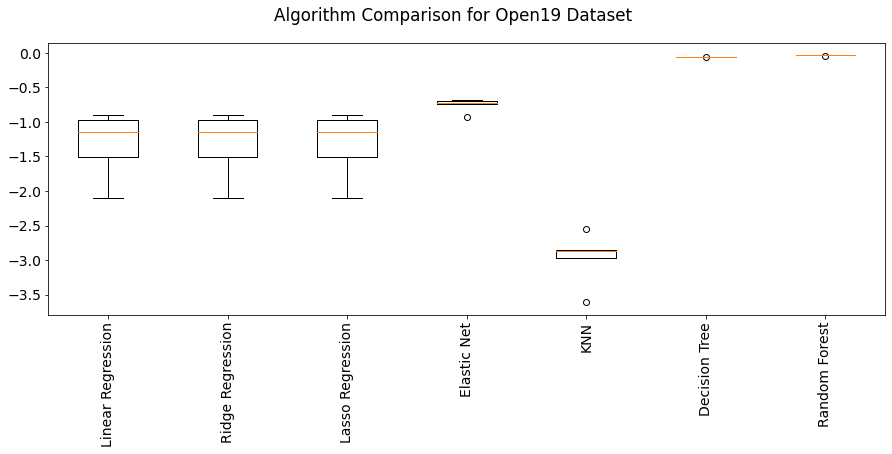

In [300]:
plt.rcParams.update({'figure.figsize': (15,5)})
plt.rcParams.update({'font.size': 14})
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison for Open19 Dataset')
ax = fig.add_subplot(111)
plt.boxplot(results_models)
plt.xticks(rotation = 90)
ax.set_xticklabels(names)
plt.show()

The Random Forest Regressor show together with the Decision Tree Regressor the best results for the given dataset. Since Random Forests can handle numerical and categorical features well and the already integrated feature importance can help identifying most important features, the Random Forest Regressor is the algorithm of choice.

---
## Selection of best Dataset

In this section several combinations of data from Data Preparation Notebook are used for the Random Forest algorithm to show the impact of each dataset. At the end the best data combination will be used for the final regression model.

In [270]:
# define filenames of the datasets in a list
dataset_names = ['prep_rank_01_19','prep_rank_02_19imp','prep_rank_03_19_hw', \
                 'prep_rank_04_19imp_hw','prep_rank_05_19_bs','prep_rank_06_19imp_bs', \
                 'prep_rank_07_19_hw_bs','prep_rank_08_19imp_hw_bs','prep_rank_09_19_bsimp', \
                 'prep_rank_10_19imp_bsimp','prep_rank_11_19_hw_bsimp', \
                 'prep_rank_12_19imp_hw_bsimp']

In [272]:
results = []

for i in range(len(dataset_names)):

    # import dataset
    df = pd.read_csv(f'./data/{dataset_names[i]}.csv')
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    # define target and features
    y = df['overallrank']
    X = df.drop(axis=1,columns='overallrank')
    
    # train test split for model evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RSEED)
        
    # define numerical features for scaling
    scale_cols = ['age', \
                  'w1_reps_total', \
                  'w2_reps_t2b','w2_reps_du','w2_reps_sqcl', \
                  'w3_5ft_reps_ohl','w3_reps_dbbsu','w3_reps_hspu','w3_5ft_reps_hsw', \
                  'w4_reps_sn','w4_reps_bp','w4_reps_bmu', \
                  'w5_reps_total']
    # add heights and weights if necessary
    if 'hw' in dataset_names[i]:
        scale_cols.append('height')
        scale_cols.append('weight')
    # add olympic lifts if necessary
    if 'bs' in dataset_names[i]:
        scale_cols.append('bs_backsquat')
        scale_cols.append('bs_cleanandjerk')
        scale_cols.append('bs_snatch')
        scale_cols.append('bs_deadlift')
    
    # scaling numerical features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[scale_cols])
    X_test_scaled = scaler.transform(X_test[scale_cols])
    
    # imputing missing features via KNN
    imputer = KNNImputer()
    X_train_imputed = imputer.fit_transform(X_train_scaled)
    X_test_imputed = imputer.fit_transform(X_test_scaled)
    
    # concatenate numerical and categorical features
    X_train_prep = np.concatenate([X_train_imputed, X_train.drop(scale_cols,axis=1)], axis=1)
    X_test_prep = np.concatenate([X_test_imputed, X_test.drop(scale_cols,axis=1)], axis=1)
    
    # define and fit the model
    model = RandomForestRegressor()
    scoring = 'neg_mean_absolute_percentage_error'
    kfold = model_selection.KFold(n_splits=5, random_state=RSEED, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_train_prep, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    msg = "%s: %f (%f)" % (dataset_names[i], cv_results.mean(), cv_results.std())
    print(msg)

prep_rank_01_19: -0.040339 (0.000343)
prep_rank_02_19imp: -0.032739 (0.000336)
prep_rank_03_19_hw: -0.040740 (0.000261)
prep_rank_04_19imp_hw: -0.033609 (0.000277)
prep_rank_05_19_bs: -0.064103 (0.004164)
prep_rank_06_19imp_bs: -0.056783 (0.002653)
prep_rank_07_19_hw_bs: -0.064610 (0.004460)
prep_rank_08_19imp_hw_bs: -0.057712 (0.002993)
prep_rank_09_19_bsimp: -0.042182 (0.000764)
prep_rank_10_19imp_bsimp: -0.034584 (0.000379)
prep_rank_11_19_hw_bsimp: -0.042420 (0.000514)
prep_rank_12_19imp_hw_bsimp: -0.035163 (0.000450)


In [274]:
#results_best_dataset = results

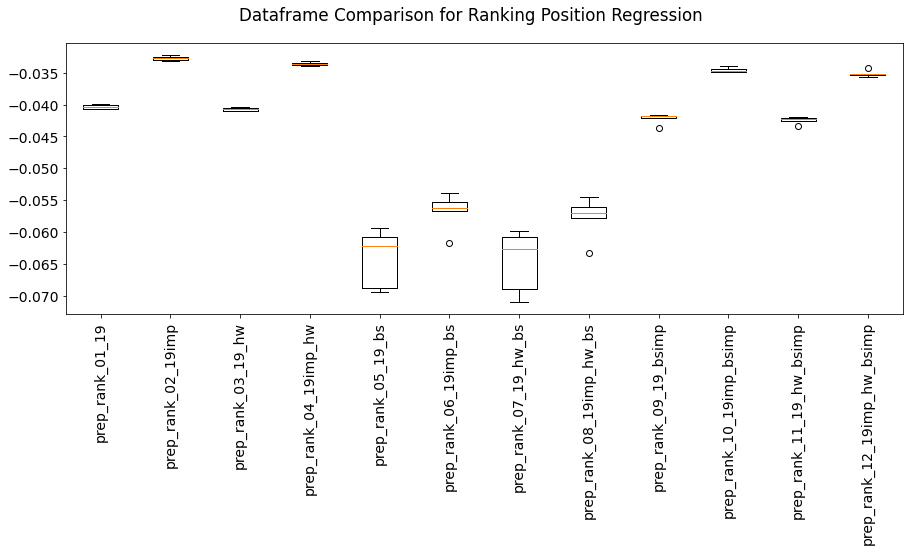

In [291]:
plt.rcParams.update({'figure.figsize': (15,5)})
plt.rcParams.update({'font.size': 14})
# Compare Dataframes
fig = plt.figure()
fig.suptitle('Dataframe Comparison for Ranking Position Regression')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.xticks(rotation = 90)
ax.set_xticklabels(dataset_names)
plt.show()

The worst performances are of datasets with complete case olympic lift records while the best performances are of datasets with KNN-imputed Open workout results. Amongst them the best dataset seems to be the 2nd dataset with KNN-imputed Open workout results only (without lifts or body measurements).

---
## Model Building

With the help of the selected algorithm and the most promising dataset, in this section the first Random Forest Regression model is build and analyzed.

In [344]:
# load the dataset
df_reg = pd.read_csv('./data/prep_rank_02_19imp.csv')
df_reg = df_reg.loc[:, ~df_reg.columns.str.contains('^Unnamed')]
# create train and test sets
train_set, test_set = train_test_split(df_reg,test_size=0.3,random_state=RSEED)
# define target and features
y = train_set['overallrank']
X = train_set.drop(axis=1,columns='overallrank')
# train test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RSEED)
# define numerical features for scaling
scale_cols = ['age', \
              'w1_reps_total', \
              'w2_reps_t2b','w2_reps_du','w2_reps_sqcl', \
              'w3_5ft_reps_ohl','w3_reps_dbbsu','w3_reps_hspu','w3_5ft_reps_hsw', \
              'w4_reps_sn','w4_reps_bp','w4_reps_bmu', \
              'w5_reps_total']
# scaling numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[scale_cols])
X_test_scaled = scaler.transform(X_test[scale_cols])
# concatenate numerical and categorical features
X_train_prep = np.concatenate([X_train_scaled,X_train.drop(scale_cols,axis=1)],axis=1)
X_test_prep = np.concatenate([X_test_scaled,X_test.drop(scale_cols,axis=1)],axis=1)

In [346]:
# define the regression model
model_reg = RandomForestRegressor(n_estimators = 100, n_jobs = -1, oob_score = True, \
                                  bootstrap = True, random_state=RSEED)
model_reg.fit(X_train_prep, y_train)

RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=42)

In [347]:
# output of training results
print('R^2 Training Score: {:.4f} \nOOB Score: {:.4f} \nR^2 Validation Score: {:.4f}'.format(
    model_reg.score(X_train_prep,y_train),
    model_reg.oob_score_,
    model_reg.score(X_test_prep,y_test)))

R^2 Training Score: 0.9996 
OOB Score: 0.9969 
R^2 Validation Score: 0.9969


The score is good enough for the purpose of identifying most sensitive features. Thus, no hyperparameter tuning is necessary.

In [348]:
# get score for test set
y_test_set = test_set['overallrank']
X_test_set = test_set.drop(axis=1,columns='overallrank')
X_test_set_scaled = scaler.transform(X_test_set[scale_cols])
X_test_set_prep = np.concatenate([X_test_set_scaled,X_test_set.drop(scale_cols,axis=1)],axis=1)
model_reg.score(X_test_set_prep,y_test_set)

0.9970620541969178

Also the R2-Score of our regression model is high enough to proceed with the sensitivity analysis.

---
## Sensitivity Analysis

In this section the sensitivity analysis is performed to identify most important/sensitive workout movements for a better ranking position. On the one hand the Random Forest Regressor is provided with a feature importance output and on the other hand a sensitivity analysis is carried out.

### Feature Importance

In [377]:
importance = model_reg.feature_importances_

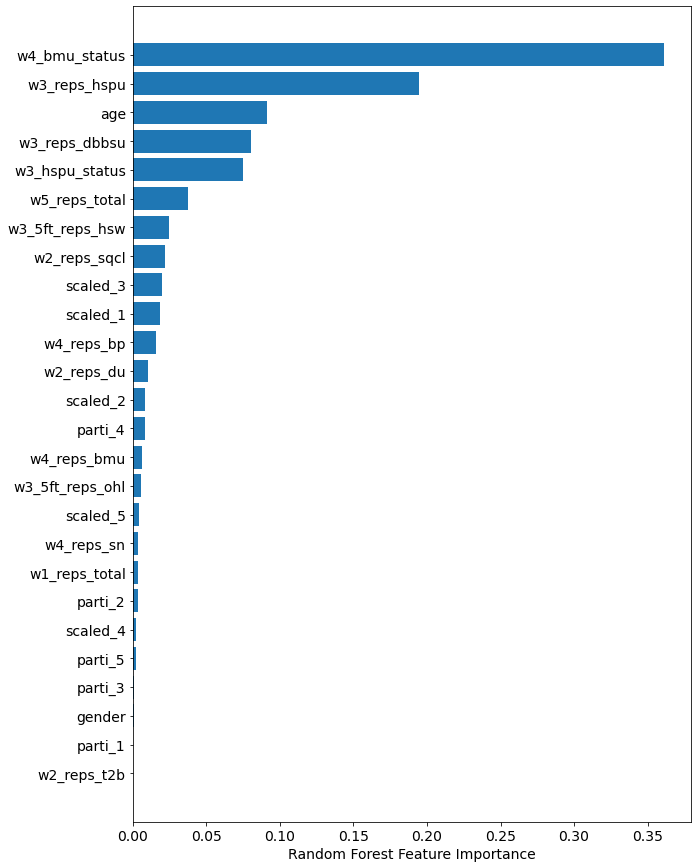

In [378]:
plt.rcParams.update({'figure.figsize': (10, 15)})
plt.rcParams.update({'font.size': 14})
sorted_idx = importance.argsort()
plt.barh(X.columns[sorted_idx], importance[sorted_idx])
plt.xlabel("Random Forest Feature Importance");

In the above shown picture there are the most important features listed (in an descending order) who are responsible for predicting the overall ranking position in CrossFit Open 2019.

Both numerical and categorical features are taken into account. Several features do not make sense at first sight. For instance the age is not directly related to the workout results. The gender seem to have no effect on the ranking but it should, since there are less men than women (results in a reduced average ranking position). It also might be expected that the Squat-Cleans, total reps of 19.1 and Bar Muscle-Up repetions are more important.

Future work: seperate models for male/female athletes as well as Rx and scaled divisions.

### Sensitivities of Workout Movements

In [359]:
features = list(X.columns)

In [391]:
my_list = [0]*len(features)
my_array = np.asarray([my_list])
result = model_reg.predict(my_array)
rank_ref = result[0]

list_pos_1 = []
list_pos_2 = []
list_pos_2_add = []
list_neg_1 = []
list_neg_2 = []
list_neg_2_add = []

for i in range(len(features)):
    
    my_list[i] = 1.0
    my_array = np.asarray([my_list])
    result = model_reg.predict(my_array)
    a = round(((rank_ref - result[0])*100 / rank_ref),1)
    list_pos_1.append(a)
    my_list = [0]*len(features)
    
    my_list[i] = 2.0
    my_array = np.asarray([my_list])
    result = model_reg.predict(my_array)
    b = round(((rank_ref - result[0])*100 / rank_ref),1)
    list_pos_2.append(b)
    list_pos_2_add.append(b-a)
    my_list = [0]*len(features)
    
    my_list[i] = -1.0
    my_array = np.asarray([my_list])
    result = model_reg.predict(my_array)
    c = round(((rank_ref - result[0])*100 / rank_ref),1)
    list_neg_1.append(c)
    my_list = [0]*len(features)
    
    my_list[i] = -2.0
    my_array = np.asarray([my_list])
    result = model_reg.predict(my_array)
    d = round(((rank_ref - result[0])*100 / rank_ref),1)
    list_neg_2.append(d)
    list_neg_2_add.append(d-c)
    my_list = [0]*len(features)
    
df_sens = pd.DataFrame(
    index=features,
    data=list(zip(
        list_pos_1,
        list_pos_2_add,
        list_neg_1,
        list_neg_2_add)),
    columns=['+1 sigma','+2 sigma','-1 sigma','-2 sigma'])

In [392]:
wod_idx = ['w1_reps_total', \
           'w2_reps_t2b','w2_reps_du','w2_reps_sqcl', \
           'w3_5ft_reps_ohl','w3_reps_dbbsu','w3_reps_hspu','w3_5ft_reps_hsw', \
           'w4_reps_sn','w4_reps_bp','w4_reps_bmu', \
           'w5_reps_total']

In [393]:
df_x = df_sens.loc[wod_idx]
df_x

,+1 sigma,+2 sigma,-1 sigma,-2 sigma
w1_reps_total,-0.1,0.0,0.0,0.0
w2_reps_t2b,0.0,0.0,0.0,0.0
w2_reps_du,0.8,0.0,-2.0,-0.7
w2_reps_sqcl,-1.5,0.1,-30.4,-22.3
w3_5ft_reps_ohl,0.4,-1.9,-6.9,0.0
w3_reps_dbbsu,15.4,0.1,-4.1,-24.9
w3_reps_hspu,-151.0,0.0,0.0,0.0
w3_5ft_reps_hsw,-79.0,0.0,0.0,0.0
w4_reps_sn,-4.8,0.0,0.0,0.0
w4_reps_bp,-18.6,0.0,0.0,0.0


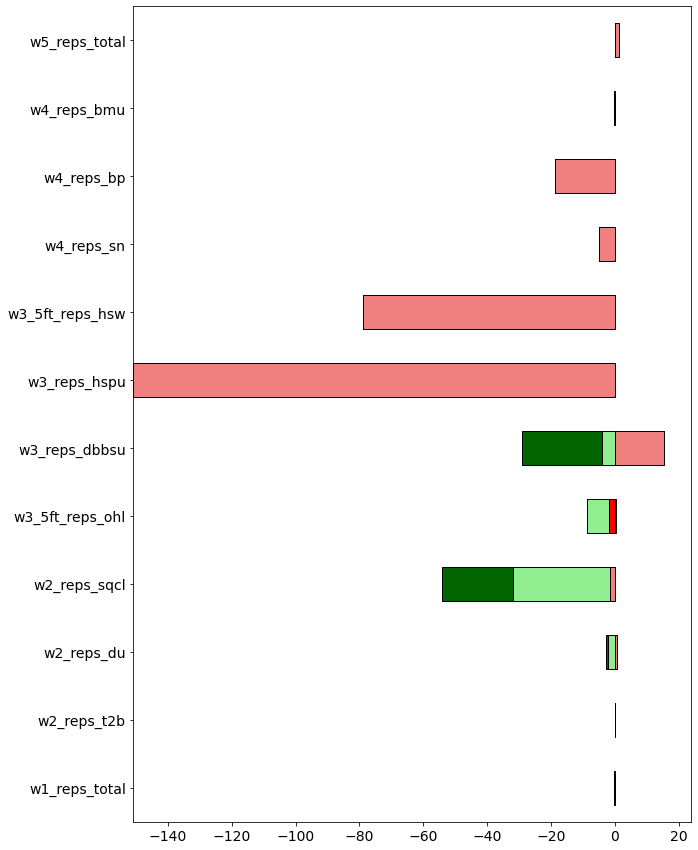

In [394]:
sens_colors = ['lightcoral','red','lightgreen','darkgreen']
df_x.plot.barh(stacked=True, edgecolor='black', color=sens_colors, legend=False);

In the above shown picture is a diverging barplot visible. Changes in the amount of 1 and 2 standard deviations from mean (in both positive and negative directions) result in changes of the overall ranking position. Green means a positive effect and red a negative effect. Also here are results which were not expected.

Future work: seperate models for male/female athletes as well as Rx and scaled divisions.